In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import planarity
from networkx.algorithms import community
import make_mst
import make_pmfg

In [2]:
raw_data = pd.read_csv('cleaned_data.csv',index_col=0)

# of nodes, 63
# of edges, 1953


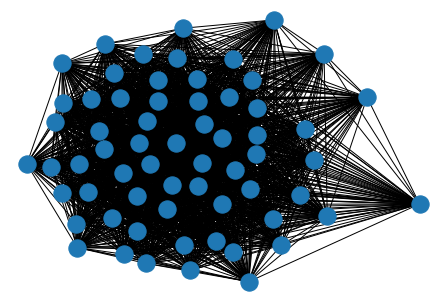

In [3]:
## corr 算法

G = make_mst.get_graph_corr('2010-11')
nx.draw(G)
# G.edges(data=True)
# sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = True)
print('# of nodes,', nx.number_of_nodes(G))
print('# of edges,', nx.number_of_edges(G))


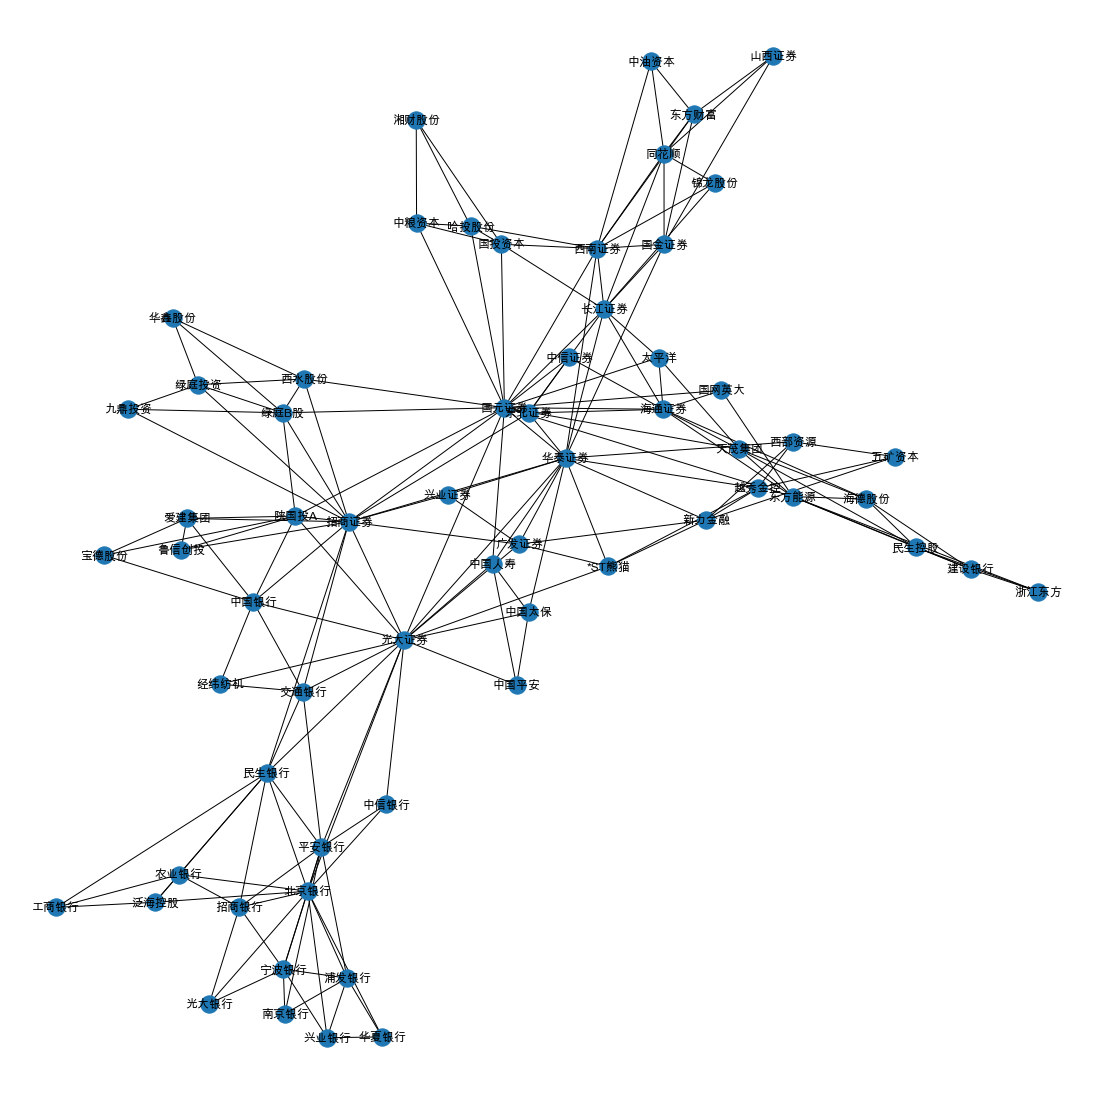

In [4]:
pfmg = make_pmfg.compute_PMFG(G)
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_spring(pfmg,with_labels=True)

# of nodes, 63
# of edges, 2016


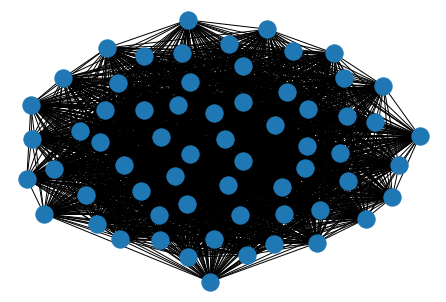

In [5]:
## distance 算法

G = make_mst.get_graph_distance('2010-11')
nx.draw(G)
# G.edges(data=True)
# sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = True)
print('# of nodes,', nx.number_of_nodes(G))
print('# of edges,', nx.number_of_edges(G))

In [ ]:
pfmg = make_pmfg.compute_PMFG(G)
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_spring(pfmg,with_labels=True)